In [2]:
import torch
print(torch.__version__, torch.cuda.is_available())

2.6.0+cu124 True


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "data/train/_annotations.coco.json", "data/train")
register_coco_instances("my_dataset_val", {}, "data/valid/_annotations.coco.json", "data/valid")
register_coco_instances("my_dataset_test", {}, "data/test/_annotations.coco.json", "data/test")

WARNING [03/20 16:44:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/20 16:44:00 d2.data.datasets.coco]: Loaded 1766 images in COCO format from data/train/_annotations.coco.json


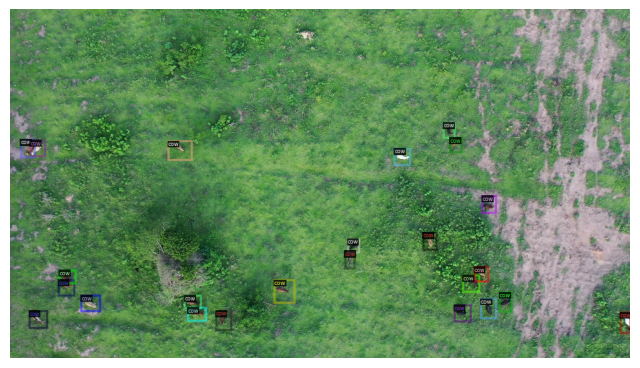

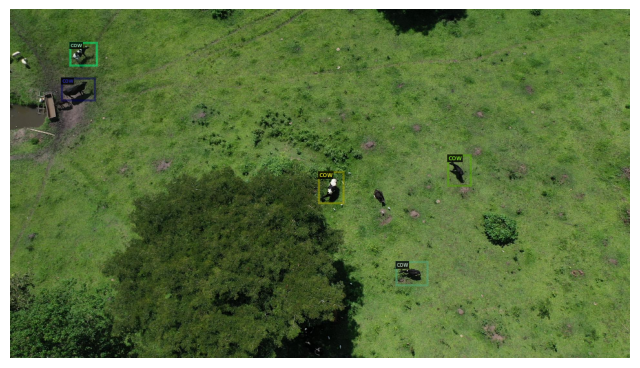

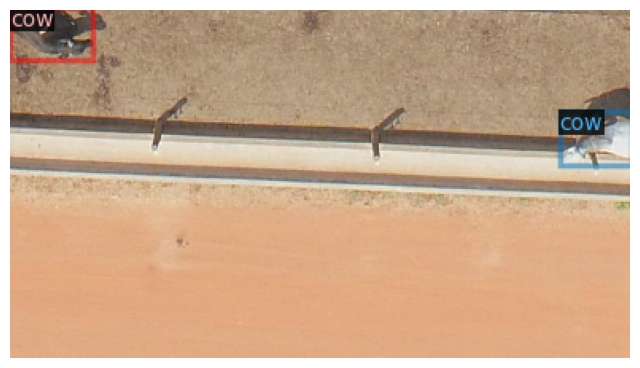

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

     # Convert BGR to RGB for Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(vis.get_image())  
    plt.axis("off")  # Hide axes
    plt.show()

In [ ]:
Train custom data

In [6]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/ffaster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1400)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [16]:
cfg.OUTPUT_DIR

'./output'

In [17]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output